# Time series - multivariate prediction, data preprocessing

In this example, we will use `pandas` to load and prepare dataset for multivariate prediction.

The dataset is from Prague airport daily weather measurements.

In [ ]:
import numpy as np
import os
from datetime import date
import re

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.options.display.max_rows = 30

Download the data archive and unpack (see the file structure in the VM drive explorer)

In [ ]:
!wget https://raw.githubusercontent.com/mlcollege/time-series-analysis/master/data/weather.zip

--2022-10-26 10:55:23--  https://raw.githubusercontent.com/mlcollege/time-series-analysis/master/data/weather.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 339742 (332K) [application/zip]
Saving to: ‘weather.zip’

weather.zip         100%[===================>] 331.78K  --.-KB/s    in 0.03s   

2022-10-26 10:55:24 (9.57 MB/s) - ‘weather.zip’ saved [339742/339742]



In [ ]:
import zipfile

with zipfile.ZipFile('/content/weather.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

First, let's prepare some constants

In [ ]:
days = {str(y) for y in range(1, 32)}
months = dict(zip(
    ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'),
    range(1, 13)
))            
years = {str(y) for y in range(1996, 2018)}

rain_flags = ['Thunderstorm', 'Rain', 'Hail', 'Snow']

def triple(col_name):
    return [col_name + '[hi]', col_name + '[av]', col_name + '[lo]']

columns = ['Temp', 'DPoint', 'Humidity', 'SLPress', 'Vis', 'Wind']
all_columns = [t for col in columns for t in triple(col)] + ['Precip[sum]', 'Precip[0-1]']

def floatOrNaN(token):
    try:
        return float(token)
    except ValueError:
        return np.NaN

Here's the set of all columns for the whole database.

In [ ]:
print('\n'.join(all_columns))

Temp[hi]
Temp[av]
Temp[lo]
DPoint[hi]
DPoint[av]
DPoint[lo]
Humidity[hi]
Humidity[av]
Humidity[lo]
SLPress[hi]
SLPress[av]
SLPress[lo]
Vis[hi]
Vis[av]
Vis[lo]
Wind[hi]
Wind[av]
Wind[lo]
Precip[sum]
Precip[0-1]


Now, let's prepare a method for loading dataset into pandas dataframe:

In [ ]:
def load_to_dataframe(file_path):
    print('Loading: %s... ' % file_path, end='')
    with open(file_path) as file:
        lines = [line for line in file]

    if not lines[-1].endswith('\n'):
        lines[-1] = lines[-1] + '\n'

    tokens = re.split('[\t\n]', lines[0])[:-1]    
    if tokens[0] not in years:
        raise ValueError('Year expected: %s' % tokens[0])    
    current_year = tokens[0]

    tokens = re.split('[\t\n]', lines[1])[:-1]    
    if tokens[0] not in months:
        raise ValueError('Month expected: %s' % tokens[0])    
    current_month = tokens[0]

    dates = []
    values = []

    for line in lines[2:]:        
        tokens = re.split('[\t\n]', line)[:-1]    
        if tokens[0] in years:
            current_year = tokens[0]
        elif tokens[0] in months:
            current_month = tokens[0]
        elif tokens[0] in days:
            dates.append(date(int(current_year), months[current_month], int(tokens[0])))            
            has_rain = any(rf in tokens[-1] for rf in rain_flags)
            numbers = np.array([floatOrNaN(token) for token in tokens[1:-1]] + [1 if has_rain else 0])
            if numbers.shape[0] != 20:
                raise ValueError('Invalid row: %s %s' % (current_month, " ".join(tokens)))
            values.append(numbers)
        else:
            raise ValueError('Unexpected token: %s' % tokens[0])
                
    df = pd.DataFrame(np.stack(values), columns=all_columns, index=pd.DatetimeIndex(dates, freq='infer'))            
    if df.index.freq == 'D':
        print("%d rows." % len(values))
    else:
        print('%d rows. Warning! missing rows.' % len(values))        
    return df    

Load the dataset into a list of dataframes, one dataframe per year:

In [ ]:
DATA_PATH = '/content/weather/LKPR/'
files = sorted([filenames for dirpath, dirnames, filenames in os.walk(DATA_PATH)][0])

df_years = []

for file in sorted(files):
    df_years.append(load_to_dataframe(DATA_PATH + file))

Loading: /content/weather/LKPR/LKPR_1996.csv... 184 rows.
Loading: /content/weather/LKPR/LKPR_1997.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_1998.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_1999.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2000.csv... 268 rows. Warning! missing rows.
Loading: /content/weather/LKPR/LKPR_2001.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2002.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2003.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2004.csv... 366 rows.
Loading: /content/weather/LKPR/LKPR_2005.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2006.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2007.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2008.csv... 366 rows.
Loading: /content/weather/LKPR/LKPR_2009.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2010.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2011.csv... 365 rows.
Loading: /content/weather/LKPR/LKPR_2012.csv... 3

We have some missing values (more then a half year gap) in the data. 

Let's take only data after the gap and make one long sequence out of all consecutive years

In [ ]:
df = pd.concat(df_years[5:])

Let's see how the data looks like

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp[hi],6209.0,13.247705,9.406100,-12.0,6.0,13.0,21.0,37.00
Temp[av],6209.0,8.855532,8.084519,-15.0,3.0,9.0,16.0,28.00
Temp[lo],6209.0,4.753745,7.094816,-22.0,0.0,5.0,11.0,20.00
DPoint[hi],6209.0,7.050894,6.841259,-17.0,2.0,7.0,13.0,23.00
DPoint[av],6209.0,4.775970,6.745361,-19.0,0.0,5.0,10.0,20.00
DPoint[lo],6209.0,2.311322,6.850615,-24.0,-2.0,3.0,8.0,17.00
Humidity[hi],6209.0,93.370108,6.525494,49.0,88.0,94.0,100.0,100.00
Humidity[av],6209.0,76.550652,12.115267,32.0,68.0,78.0,86.0,100.00
Humidity[lo],6209.0,55.804155,18.720776,9.0,41.0,55.0,71.0,94.00
SLPress[hi],6209.0,1019.194395,7.739584,981.0,1015.0,1019.0,1024.0,1045.00


## Data selection

For our prediction we are going to select the following columns:

- **average temperature** (cont. value)
- **averate temperature of the dew point** (cont. value)
- **sea level pressure** (cont. value)
- **precipitation** (cont. value)

Let's see our data for the last year.

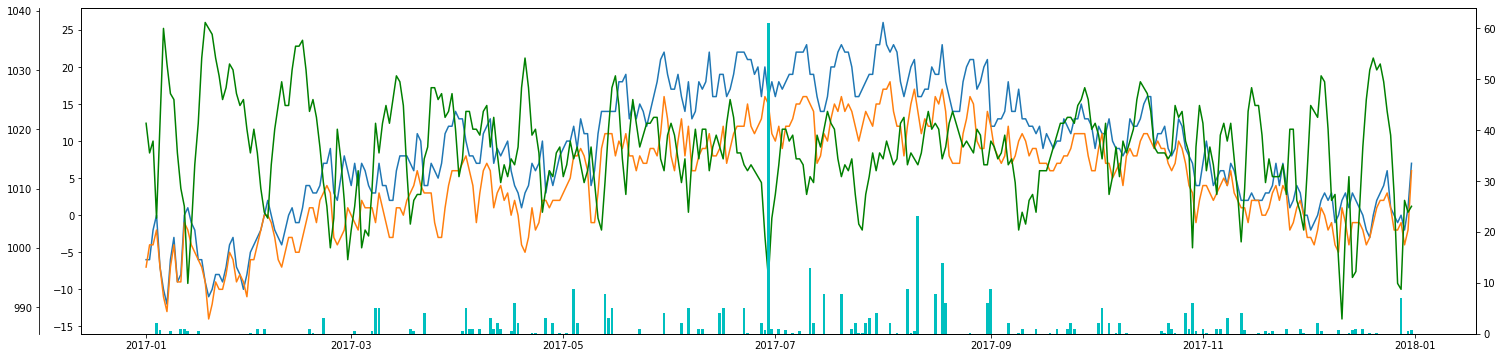

In [ ]:
start_date = '2017-01-01'
end_date = '2017-12-31'

plt.figure(figsize = (25, 6))
plt.plot(df[start_date:end_date]['Temp[av]'])
plt.plot(df[start_date:end_date]['DPoint[av]'])
ax = plt.twinx()
ax.spines['left'].set_position(("axes", -0.03))
plt.plot(df[start_date:end_date]['SLPress[av]'], c='g')
plt.twinx()
plt.bar(df[start_date:end_date].index, df['Precip[sum]'][start_date:end_date], color='c')
plt.show()

The data has wildly different bounds and there are some outliers as well. We need some normalization.
Let's normalize with mean and standard deviation (see how precipitation is normalized differently)

In [ ]:
selected_df = pd.concat((df[c] for c in ['Temp[av]', 'DPoint[av]', 'SLPress[av]']), axis=1)
norm_df = (selected_df - selected_df.mean()) / selected_df.std()

norm_p = df['Precip[sum]'] / 10.0

Normalized data looks way better:

[]

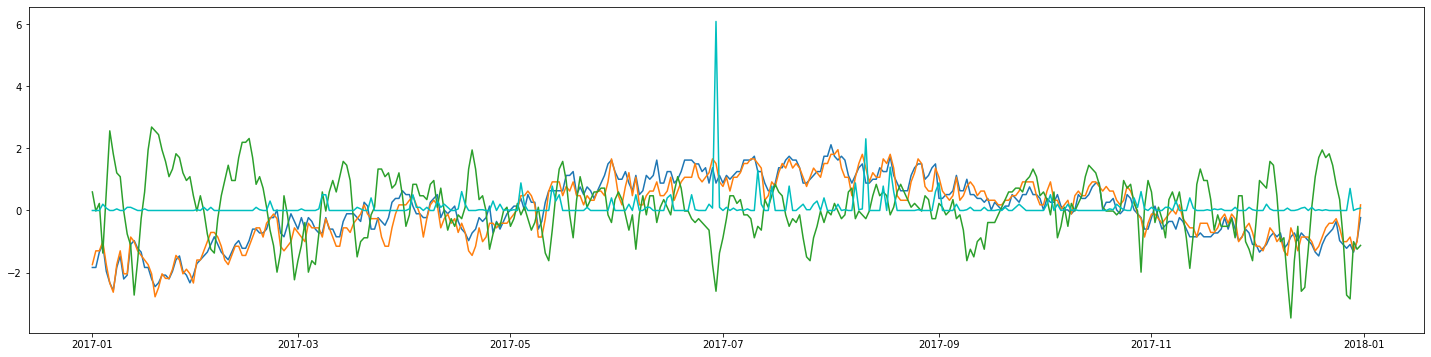

In [ ]:
plt.figure(figsize = (25, 6))
plt.plot(norm_df[start_date:end_date])
plt.plot(norm_p[start_date:end_date], c='c')
plt.plot()

## Data augmentation
Let's add one more input feature -- *day of the year*. The idea is that such a feature should predict the temperature quite nicely.

As the simple number of a day of the year would have a discontinuity at each year's end, we will use *circular encoding*. Let's test the encoding first:

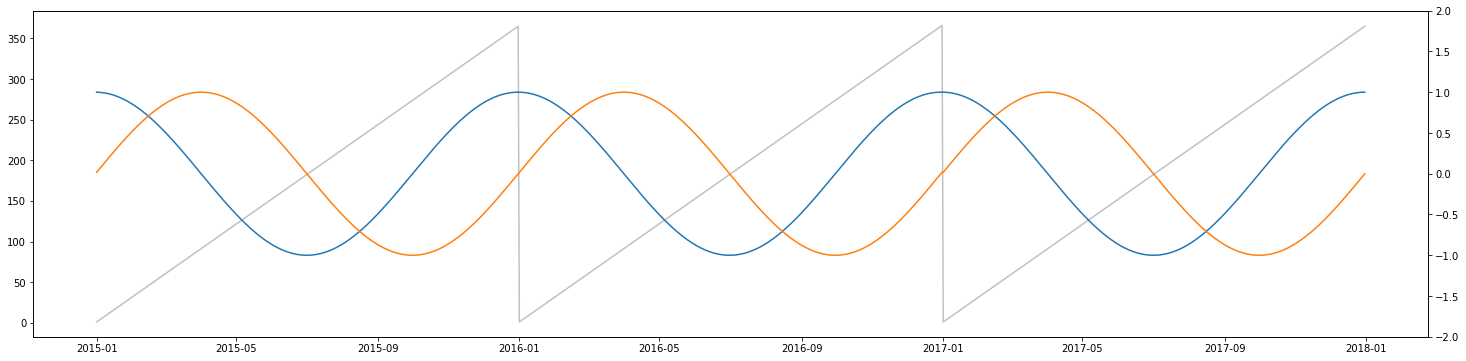

In [ ]:
_index = df['2015-01-01': '2018-01-01'].index
plt.figure(figsize = (25, 6))
plt.plot(_index, _index.dayofyear, color='silver')
plt.twinx()
plt.ylim(-2,2)
plt.plot(_index, np.cos(_index.dayofyear / 365.0 * 2.0 * np.pi))
plt.plot(_index, np.sin(_index.dayofyear / 365.0 * 2.0 * np.pi))

Now, let's apply it to the whole dataframe date index:

In [ ]:
phi = df.index.dayofyear.values / 365.0 * 2.0 * np.pi
doy = pd.DataFrame(np.stack((np.cos(phi), np.sin(phi)), axis=-1), df.index, columns=['cos(DoY)', 'sin(DoY)'])

Finally, concatenate continuous value columns with precipitaion and store the dataset for later use.

In [ ]:
all_features = pd.concat((norm_df, norm_p, doy), axis=1)
all_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp[av],6209.0,-6.294065e-17,1.000000,-2.950767,-0.724290,1.786967e-02,0.883722,2.368041
DPoint[av],6209.0,-8.926129e-17,1.000000,-3.524788,-0.708038,3.321240e-02,0.774463,2.256963
SLPress[av],6209.0,-3.497211e-15,1.000000,-4.944317,-0.633782,-1.799073e-02,0.597800,3.184121
Precip[sum],6209.0,3.121839e-02,0.179307,0.000000,0.000000,0.000000e+00,0.000000,6.096000
cos(DoY),6209.0,6.441307e-04,0.707391,-0.999963,-0.708627,4.303538e-03,0.702527,1.000000
sin(DoY),6209.0,1.108929e-05,0.706936,-0.999991,-0.705584,-2.449294e-16,0.705584,0.999991


In [ ]:
TESTING_SET_LEN = 365
training_df = all_features[:-TESTING_SET_LEN]
testing_df = all_features[-TESTING_SET_LEN:]

In [ ]:
OUT_PATH = '/content/'
testing_df.to_pickle(OUT_PATH + 'testing_set_temp_dp_press.p')
training_df.to_pickle(OUT_PATH + 'training_set_temp_dp_press.p')